# Here we build a RAG using LangGraph using Astra DB from Datasax . This would be a multi agent framework architecture as shown.The architecture uses Llama 3.1 LLM as the Gen ai model via GROQ 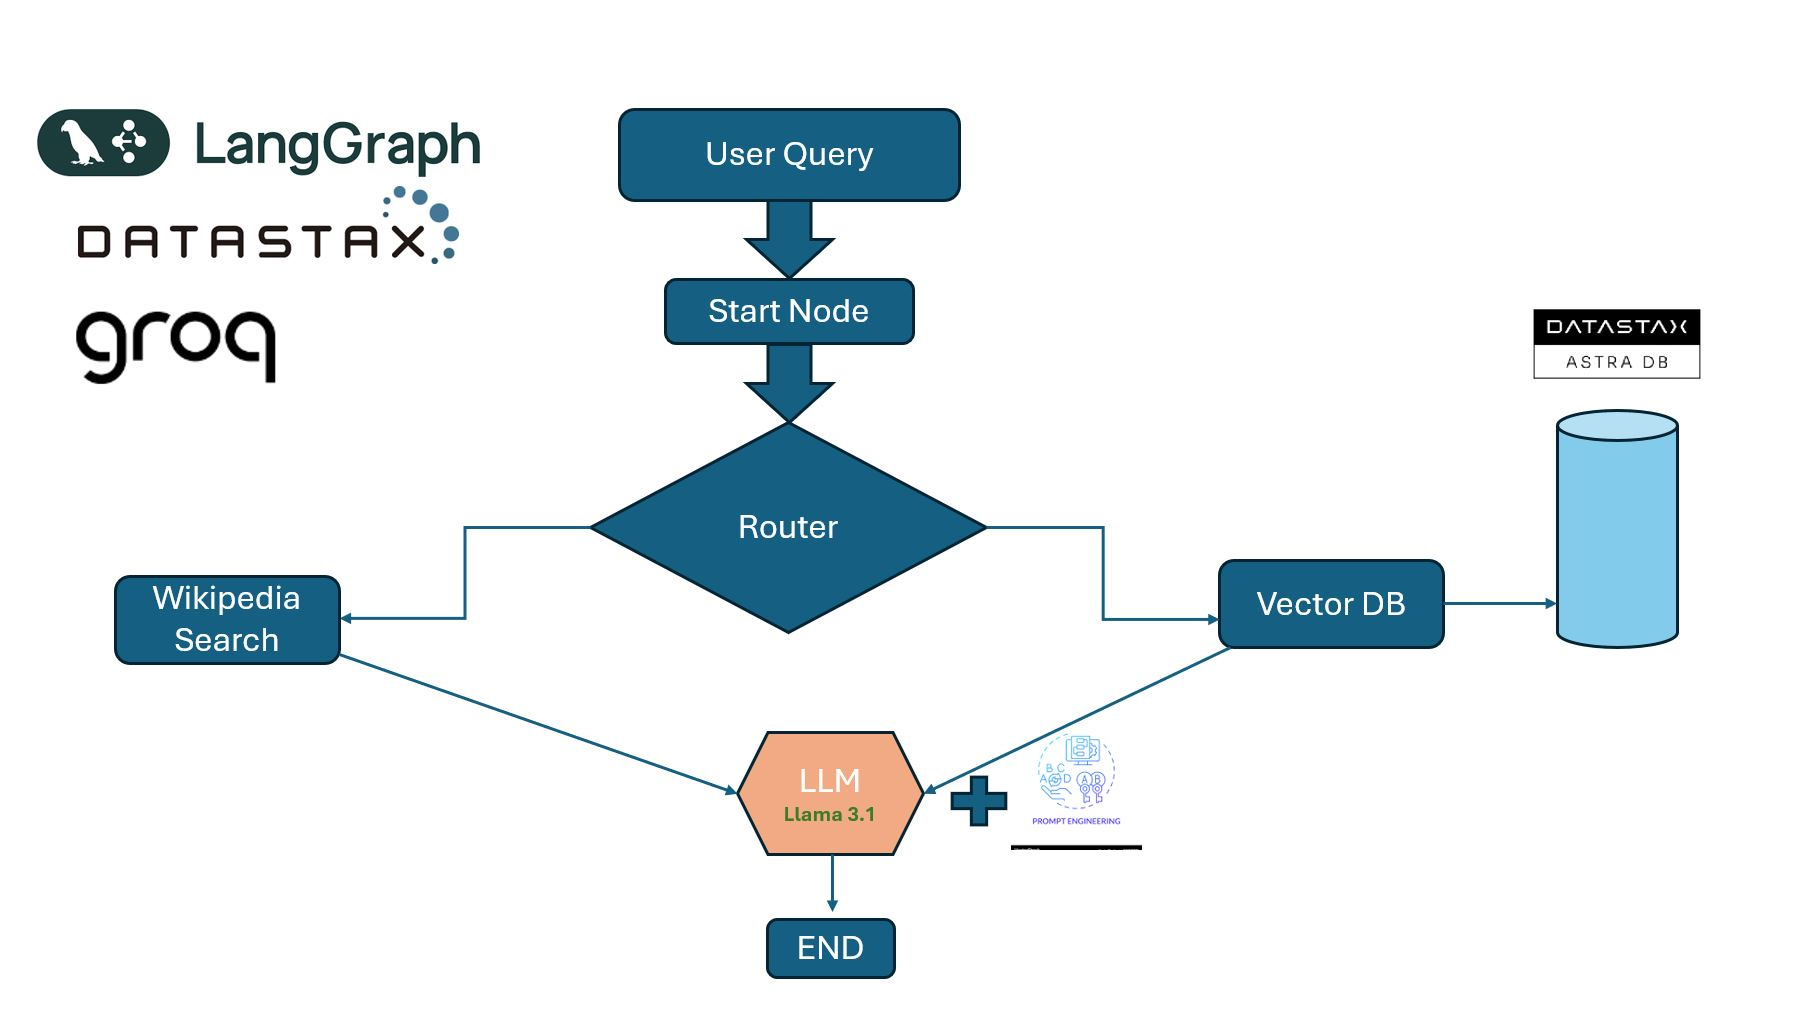

In [ ]:
!pip install langchain langgraph cassio
# Cassio is a separate open-source package that provides additional
# functionality for working with Apache Cassandra %%

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existin

Setup the connection to astra DB and initialize it now !!

In [ ]:
import cassio
ASTRA_DB_APPLICATION_TOKEN = "AstraCS:HDgqLtYZiRWIOJJINwILZBRj:ce3cd8eff5bd2ccdc35012020f1986eb1f4a24ac6074cdb1325f91ac25360411"
ASTRA_DB_ID="9b3de0cd-8279-4b34-b7db-2c159d7d02f8"
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [ ]:
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install -U langchain_community tiktoken langchain-groq langchainhub langchain langgraph langchain_huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 6.6 MB/s eta 0:00:00


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

# Docs to index

In [ ]:
urls = [
        "https://deeprevision.github.io/posts/001-transformer/",
        "https://lilianweng.github.io/posts/2023-06-23-agent/",
        "https://developer.nvidia.com/blog/nvidia-blackwell-platform-sets-new-llm-inference-records-in-mlperf-inference-v4-1/"
]

In [ ]:
# Load the data
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)

In [ ]:
docs_list

#huggingFace embeddings model & Vector store in astra

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(embedding=embeddings,
                             table_name ='db221_me_rag',
                             session=None,
                             keyspace=None)

In [ ]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(docs_list)

['90a20be5abb34b658116937060b64fb5',
 'c6d255f7cfde48cabc6cf976f53cfe05',
 '722585caab384c7f8365f3fc887cb021']

In [ ]:
print("Inserted %i headlines." % len(doc_splits))
astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 97 headlines.


## Reterive the data from astra_vector_index to check the data

In [ ]:
retriever=astra_vector_store.as_retriever()
retriever.invoke("What is transformer",ConsistencyLevel="LOCAL_ONE")

[Document(metadata={'description': 'A deep dive into Transformer, a neural network architecture that was introduced in the famous paper “attention is all you need” in 2017, its applications, impacts, challenges and future directions', 'language': 'en', 'source': 'https://deeprevision.github.io/posts/001-transformer/', 'title': 'AI Research Blog - The Transformer Blueprint: A Holistic Guide to the Transformer Neural Network Architecture'}, page_content='\n\n\n\n\n\n\n\nAI Research Blog - The Transformer Blueprint: A Holistic Guide to the Transformer Neural Network Architecture\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAI Research Blog\n\n\n\n\n\n\n\n\n\n\nAbout\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n \n\n\n\n\n\n\nThe Transformer Blueprint: A Holistic Guide to the Transformer Neural Network A

# Router function in LangGraph application

In [ ]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


### Use the BaseModel

In [ ]:
# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

# GroQ LLM and setup

In [ ]:
from google.colab import userdata
# LLM with function call
from langchain_groq import ChatGroq
import os

groq_api_key=userdata.get('llama_3.1_groq')
os.environ["GROQ_API_KEY"]=groq_api_key
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Llama-3.1-70b-Versatile")

In [ ]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7940d82126e0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7940d8211720>, model_name='Llama-3.1-70b-Versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

# integrate the Route query with LLM

In [ ]:
structured_llm_router = llm.with_structured_output(RouteQuery)

In [ ]:
# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to deep learning transformer architecture,ai agent, and Nvidia MLPerf Inference v4.1 .
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

In [ ]:
question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "Who is AIRBUS?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='wiki_search'
datasource='vectorstore'


# Create WikiSearch

In [ ]:
!pip install langchain_community
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.1 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=8accf2ccd14c77f8970134eefe61dfeca93575f7de08f016b14d819fb27883fc
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=0aa69c79d3d3d03a65b8d7ffcfd55a332c44d39d918a52cb2b260957dec2344d
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built wikipedia sgmllib3k


In [ ]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

In [ ]:
## Arxiv (not using in this blog ) and wikipedia Tools
# arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
# arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [ ]:
wiki.run("PANASONIC")

'Page: Panasonic\nSummary: Panasonic Holdings Corporation is a Japanese multinational electronics company, headquartered in Kadoma, Osaka, Japan. It was founded in 1918 as Matsushita Electric Housewares'

# AI Agent Application using LangGraph

In [ ]:
## Define Graph State with three information as part of the state.

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

### Reteriver in sync with State as question,& returns documents and question. Refer the variable of the state function above

In [ ]:
from langchain.schema import Document
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval of data
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

### WikiSearch similar to reteriver. Function is to do wikipedia search and return the documents

In [ ]:
from langchain.schema import Document
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

### define the Router as a function also, its function is to decide whether wiki search or vectorstore then return the document respectively

In [ ]:
def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

# Build the Graph

In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

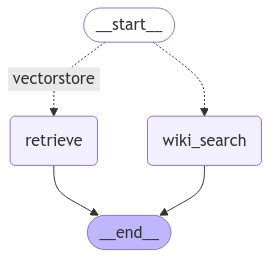

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Final Test Inference

In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview In a LLM-powered autonomous agent system, LLM '
 'functions as the agent’s brain, complemented by several key components:')


In [ ]:
# Run
inputs = {
    "question": "locomotive"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])